# Introduction

tree-boosting has the following advantages:

- Automatic modeling of non-linearities, discontinuities, and complex high-order interactions
- Robust to outliers in and multicollinearity among predictor variables
- Scale-invariance to monotone transformations of the predictor variables
- Automatic handling of missing values in predictor variables

Mixed effects models are a modeling approach for clustered, grouped, longitudinal, or panel data. Among other things, they have the advantage that they allow for more efficient learning of the chosen model for the regression function (e.g. a linear model or a tree ensemble).

Mixed effects models are a modeling approach for clustered, grouped, longitudinal, or panel data. Among other things, they have the advantage that they allow for more efficient learning of the chosen model for the regression function (e.g. a linear model or a tree ensemble).

As outlined in Sigrist (2020), combined gradient tree-boosting and mixed effects models often performs better than (i) plain vanilla gradient boosting, (ii) standard linear mixed effects models, and (iii) alternative approaches for combing machine learning or statistical models with mixed effects models.

# Modeling grouped data

Grouped data (aka clustered data, longitudinal data, panel data) occurs naturally in many applications when there are multiple measurements for different units of a variable of interest . Examples include:

- One wants to investigate the impact of some factors (e.g. learning technique, nutrition, sleep, etc.) on students’ test scores and every student does several tests. In this case, the units, i.e. the grouping variable, are the students and the variable of interest is the test score.
- A company gathers transaction data about its customers. For every, customer there are several transactions. The units are then the customers and the variable of interest can be any attribute of the transactions such as prices.

Basically, such grouped data can be modeled using four different approaches:

- Ignore the grouping structure. This is rarely a good idea since important information is neglected.

- Model each group (i.e. each student or each customer) separately. This is also rarely a good idea as the number of measurements per group is often small relative to the number of different groups.

- Include the grouping variable (e.g. student or customer ID) in your model of choice and treat it as a categorical variable. While this is a viable approach, it has the following disadvantages. Often, the number of measurements per group (e.g. number of tests per student, number of transactions per customer) is relatively small and the number of different groups is large (e.g. number of students, customers, etc.). In this case, the model needs to learn many parameters (one for every group) based on relatively little data which can make the learning inefficient. Further, for trees, high cardinality categorical variables can be problematic.

- Model the grouping variable using so-called random effects in a mixed effects model. This is often a sensible compromise between the approaches 2. and 3. above. In particular, as illustrated below and outlined in Sigrist (2020), this is beneficial compared to the other approaches in the case of tree-boosting.

# Methodological background

For the GPBoost algorithm, it is assumed that the response variable y is the sum of a non-linear mean function F(X) and so-called random effects Zb:

where
y = F(X) + Zb + e

- y the response variable (aka label)
- X contains the predictor variables (aka features) and F() is a potentially non-linear function. In linear mixed effects models, this is simply a linear function. In the GPBoost algorithm, this is an ensemble of trees.
- Zb are the random effects which are assumed to follow a multivariate normal distribution
- e is an error term

The model is trained using the GPBoost algorithm, where trainings means learning the (co-)variance parameters (aka hyper-parameters) of the random effects and the regression function F(X) using a tree ensemble. 

the GPBoost algorithm is a boosting algorithm that iteratively learns the (co-)variance parameters and adds a tree to the ensemble of trees using a gradient and/or a Newton boosting step. 

I.e., the main difference to existing boosting algorithms is that, first, it accounts for dependency among the data due to clustering and, second, it learns the hyper-parameters of the random effects. See Sigrist (2020) for more details on the methodology. 

In the GPBoost library, hyper-parameters parameters can be learned using (accelerated) gradient descent or Fisher scoring, and trees are learned using the LightGBM library. In particular, this means that the full functionality of LightGBM is available.

# Simulate data

In [2]:
import gpboost as gpb
import numpy as np
import sklearn.datasets as datasets
import time
import pandas as pd

In [3]:
# Simulate data
ntrain = 5000 # number of samples for training
n = 2 * ntrain # combined number of training and test data
m = 500  # number of categories / levels for grouping variable
sigma2_1 = 1  # random effect variance
sigma2 = 1 ** 2  # error variance

In [4]:
# Simulate non-linear mean function
np.random.seed(1)
X, F = datasets.make_friedman3(n_samples=n)
X = pd.DataFrame(X,columns=['variable_1','variable_2','variable_3','variable_4'])
F = F * 10**0.5 # with this choice, the fixed-effects regression function has the same variance as the random effects

In [5]:
# Simulate random effects
group_train = np.arange(ntrain)  # grouping variable
for i in range(m):
    group_train[int(i * ntrain / m):int((i + 1) * ntrain / m)] = i
group_test = np.arange(ntrain) # grouping variable for test data. Some existing and some new groups
m_test = 2 * m
for i in range(m_test):
    group_test[int(i * ntrain / m_test):int((i + 1) * ntrain / m_test)] = i
group = np.concatenate((group_train,group_test))
b = np.sqrt(sigma2_1) * np.random.normal(size=m_test)  # simulate random effects
Zb = b[group]

In [6]:
# Put everything together
xi = np.sqrt(sigma2) * np.random.normal(size=n)  # simulate error term
y = F + Zb + xi  # observed data
# split train and test data
y_train = y[0:ntrain]
y_test = y[ntrain:n]
X_train = X.iloc[0:ntrain,]
X_test = X.iloc[ntrain:n,]

# Learning and making predictions

In [7]:
# Define and train GPModel
gp_model = gpb.GPModel(group_data=group_train)
# create dataset for gpb.train function
data_train = gpb.Dataset(X_train, y_train)
# specify tree-boosting parameters as a dict
params = { 'objective': 'regression_l2', 'learning_rate': 0.1,
    'max_depth': 6, 'min_data_in_leaf': 5, 'verbose': 0 }

In [8]:
# train model
bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model, num_boost_round=32)
gp_model.summary() # estimated covariance parameters
# Covariance parameters in the following order:
# ['Error_term', 'Group_1']
# [0.9183072 1.013057 ]

Covariance parameters in the following order:
['Error_term', 'Group_1']
[0.9183072 1.013057 ]


In [9]:
# Make predictions
pred = bst.predict(data=X_test, group_data_pred=group_test)
y_pred = pred['fixed_effect'] + pred['random_effect_mean'] # sum predictions of fixed effect and random effect
np.sqrt(np.mean((y_test - y_pred) ** 2)) # root mean square error (RMSE) on test data. Approx. = 1.25

1.2565271489017904

# Parameter tuning

In [10]:
# Parameter tuning using cross-validation (only number of boosting iterations)
gp_model = gpb.GPModel(group_data=group_train)
cvbst = gpb.cv(params=params, train_set=data_train,
               gp_model=gp_model, use_gp_model_for_validation=False,
               num_boost_round=100, early_stopping_rounds=5,
               nfold=4, verbose_eval=True, show_stdv=False, seed=1)
best_iter = np.argmin(cvbst['l2-mean'])
print("Best number of iterations: " + str(best_iter))
# Best number of iterations: 32

[1]	cv_agg's l2: 2.95333
[2]	cv_agg's l2: 2.87809
[3]	cv_agg's l2: 2.80637
[4]	cv_agg's l2: 2.73882
[5]	cv_agg's l2: 2.67551
[6]	cv_agg's l2: 2.61607
[7]	cv_agg's l2: 2.56055
[8]	cv_agg's l2: 2.50864
[9]	cv_agg's l2: 2.46037
[10]	cv_agg's l2: 2.41501
[11]	cv_agg's l2: 2.37346
[12]	cv_agg's l2: 2.3362
[13]	cv_agg's l2: 2.30184
[14]	cv_agg's l2: 2.27357
[15]	cv_agg's l2: 2.24598
[16]	cv_agg's l2: 2.22221
[17]	cv_agg's l2: 2.20134
[18]	cv_agg's l2: 2.18237
[19]	cv_agg's l2: 2.16783
[20]	cv_agg's l2: 2.15479
[21]	cv_agg's l2: 2.14395
[22]	cv_agg's l2: 2.13474
[23]	cv_agg's l2: 2.12721
[24]	cv_agg's l2: 2.12091
[25]	cv_agg's l2: 2.11533
[26]	cv_agg's l2: 2.10954
[27]	cv_agg's l2: 2.10667
[28]	cv_agg's l2: 2.10448
[29]	cv_agg's l2: 2.10367
[30]	cv_agg's l2: 2.10226
[31]	cv_agg's l2: 2.10135
[32]	cv_agg's l2: 2.10021
[33]	cv_agg's l2: 2.099
[34]	cv_agg's l2: 2.09964
[35]	cv_agg's l2: 2.10045
[36]	cv_agg's l2: 2.10051
[37]	cv_agg's l2: 2.1005
[38]	cv_agg's l2: 2.10066
Best number of iterations

# Feature importance and partial dependence plots

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

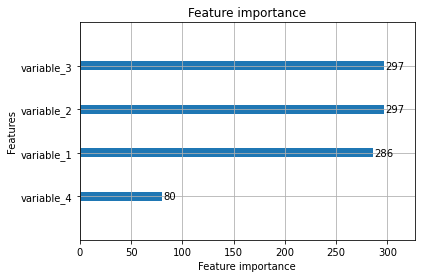

In [11]:
# Plotting feature importances
gpb.plot_importance(bst)

# PDP

In [14]:
from pdpbox import pdp
# Single variable plots
pdp_dist = pdp.pdp_isolate(model=bst, dataset=X_train,
                           model_features=X_train.columns,feature='variable_2',
                           num_grid_points=100)

pdp.pdp_plot(pdp_dist, 'variable_2', plot_lines=True)

ValueError: group_data_pred not provided

# Multivariate partial dependence plots

In [15]:
# Two variable interaction plot
inter_rf = pdp.pdp_interact(model=bst, dataset=X_train, model_features=X_train.columns,
                             features=['variable_1','variable_2'])
pdp.pdp_interact_plot(inter_rf, ['variable_1','variable_2'], x_quantile=True, plot_type='contour', plot_pdp=True)

ValueError: group_data_pred not provided

# SHAP values

In [16]:
import shap
shap_values = shap.TreeExplainer(bst).shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.dependence_plot("variable_2", shap_values, X_test)

ModuleNotFoundError: No module named 'shap'

# Comparison to alternative approaches

compare the GPBoost algorithm to several existing approaches using the above simulated data. We consider the following alternative approaches:

- A linear mixed effects model (‘Linear_ME’) where F(X) is a linear function
- Standard gradient tree-boosting ignoring the grouping structure (‘Boosting_Ign’)
- Standard gradient tree-boosting including the grouping variable as a categorical variables (‘Boosting_Cat’)
- Mixed-effects random forest (‘MERF’) (see here and Hajjem et al. (2014) for more information)

We compare the algorithms in terms of predictive accuracy measured using the root mean square error (RMSE) and computational time (clock time in seconds). 

In [23]:
results = pd.DataFrame(columns = ["RMSE","Time"],
                       index = ["GPBoost", "Linear_ME","Boosting_Ign","Boosting_Cat","MERF"])
# 1. GPBoost
gp_model = gpb.GPModel(group_data=group_train)
start_time = time.time() # measure time
bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model, num_boost_round=best_iter)
results.loc["GPBoost","Time"] = time.time() - start_time
pred = bst.predict(data=X_test, group_data_pred=group_test)
y_pred = pred['fixed_effect'] + pred['random_effect_mean'] # sum predictions of fixed effect and random effect
results.loc["GPBoost","RMSE"] = np.sqrt(np.mean((y_test - y_pred) ** 2))

# # 2. Linear mixed effects model ('Linear_ME')
# gp_model = gpb.GPModel(group_data=group_train)
# X_train_linear = np.column_stack((np.ones(ntrain),X_train))
# X_test_linear = np.column_stack((np.ones(ntrain),X_test))
# start_time = time.time() # measure time
# gp_model.fit(y=y_train, X=X_train_linear) # add a column of 1's for intercept
# results.loc["Linear_ME","Time"] = time.time() - start_time
# y_pred = gp_model.predict(group_data_pred=group_test, X_pred=X_test_linear)
# F_pred = X_test_linear.dot(gp_model.get_coef())
# results.loc["Linear_ME","RMSE"] = np.sqrt(np.mean((y_test - y_pred['mu']) ** 2))

# 3. Gradient tree-boosting ignoring the grouping variable ('Boosting_Ign')
cvbst = gpb.cv(params=params, train_set=data_train,
               num_boost_round=100, early_stopping_rounds=5,
               nfold=4, verbose_eval=True, show_stdv=False, seed=1)
best_iter = np.argmin(cvbst['l2-mean'])
print("Best number of iterations: " + str(best_iter))
# Best number of iterations: 19
start_time = time.time() # measure time
bst = gpb.train(params=params, train_set=data_train, num_boost_round=best_iter)
results.loc["Boosting_Ign","Time"] = time.time() - start_time
y_pred = bst.predict(data=X_test)
results.loc["Boosting_Ign","RMSE"] = np.sqrt(np.mean((y_test - y_pred) ** 2))

# 4. Gradient tree-boosting including the grouping variable as a categorical variable ('Boosting_Cat')
X_train_cat = np.column_stack((group_train,X_train))
X_test_cat = np.column_stack((group_test,X_test))
data_train_cat = gpb.Dataset(X_train_cat, y_train, categorical_feature=[0])
cvbst = gpb.cv(params=params, train_set=data_train_cat,
               num_boost_round=1000, early_stopping_rounds=5,
               nfold=4, verbose_eval=True, show_stdv=False, seed=1)
best_iter = np.argmin(cvbst['l2-mean'])
print("Best number of iterations: " + str(best_iter))
# Best number of iterations: 49
start_time = time.time() # measure time
bst = gpb.train(params=params, train_set=data_train_cat, num_boost_round=best_iter)
results.loc["Boosting_Cat","Time"] = time.time() - start_time
y_pred = bst.predict(data=X_test_cat)
results.loc["Boosting_Cat","RMSE"] = np.sqrt(np.mean((y_test - y_pred) ** 2))

# 5. Mixed-effects random forest ('MERF')
from merf import MERF
# rf_params={'max_depth': 6, 'n_estimators': 300}
merf_model = MERF(max_iterations=100)
print("Warning: the following takes a lot of time")
start_time = time.time() # measure time
merf_model.fit(pd.DataFrame(X_train), np.ones(shape=(ntrain,1)), pd.Series(group_train), y_train)
results.loc["MERF","Time"] = time.time() - start_time
y_pred = merf_model.predict(pd.DataFrame(X_test), np.ones(shape=(ntrain,1)), pd.Series(group_test))
results.loc["MERF","RMSE"] = np.sqrt(np.mean((y_test - y_pred) ** 2))

print(results.apply(pd.to_numeric).round(3))

[1]	cv_agg's l2: 2.85986
[2]	cv_agg's l2: 2.71862
[3]	cv_agg's l2: 2.60302
[4]	cv_agg's l2: 2.5079
[5]	cv_agg's l2: 2.43235
[6]	cv_agg's l2: 2.3709
[7]	cv_agg's l2: 2.31853
[8]	cv_agg's l2: 2.27736
[9]	cv_agg's l2: 2.24275
[10]	cv_agg's l2: 2.21561
[11]	cv_agg's l2: 2.19099
[12]	cv_agg's l2: 2.17319
[13]	cv_agg's l2: 2.16091
[14]	cv_agg's l2: 2.14851
[15]	cv_agg's l2: 2.14156
[16]	cv_agg's l2: 2.13417
[17]	cv_agg's l2: 2.13021
[18]	cv_agg's l2: 2.12591
[19]	cv_agg's l2: 2.12284
[20]	cv_agg's l2: 2.11912
[21]	cv_agg's l2: 2.11918
[22]	cv_agg's l2: 2.11704
[23]	cv_agg's l2: 2.11802
[24]	cv_agg's l2: 2.11885
[25]	cv_agg's l2: 2.1196
[26]	cv_agg's l2: 2.11938
[27]	cv_agg's l2: 2.12028
Best number of iterations: 21
[1]	cv_agg's l2: 2.85986
[2]	cv_agg's l2: 2.71862
[3]	cv_agg's l2: 2.60302
[4]	cv_agg's l2: 2.5079
[5]	cv_agg's l2: 2.43235
[6]	cv_agg's l2: 2.3709
[7]	cv_agg's l2: 2.31853
[8]	cv_agg's l2: 2.27736
[9]	cv_agg's l2: 2.24275
[10]	cv_agg's l2: 2.21541
[11]	cv_agg's l2: 2.19103
[12]	

INFO     [utils.py:141] NumExpr defaulting to 8 threads.
INFO     [merf.py:307] Training GLL is -4351.463311561931 at iteration 1.
INFO     [merf.py:307] Training GLL is -4524.798637272867 at iteration 2.
INFO     [merf.py:307] Training GLL is -4530.719728338003 at iteration 3.
INFO     [merf.py:307] Training GLL is -4488.993561732143 at iteration 4.
INFO     [merf.py:307] Training GLL is -4427.488904860089 at iteration 5.
INFO     [merf.py:307] Training GLL is -4438.485716175571 at iteration 6.
INFO     [merf.py:307] Training GLL is -4389.939419100021 at iteration 7.
INFO     [merf.py:307] Training GLL is -4383.770291783691 at iteration 8.
INFO     [merf.py:307] Training GLL is -4380.408400251073 at iteration 9.
INFO     [merf.py:307] Training GLL is -4348.7528211290355 at iteration 10.
INFO     [merf.py:307] Training GLL is -4368.453675183156 at iteration 11.
INFO     [merf.py:307] Training GLL is -4357.52476912367 at iteration 12.
INFO     [merf.py:307] Training GLL is -4372.7944449

               RMSE     Time
GPBoost       1.261    0.145
Linear_ME       NaN      NaN
Boosting_Ign  1.431    0.024
Boosting_Cat  1.290    0.045
MERF          1.276  268.837
